##  Reuters corpus topic classification

This project is about topic classification on the Reuters corpus. It is multi-label classification: there can be more than one topics associated with each document.

### Data

Test data will be extracted from XML-documents, taking input from <headline></headline> and <text></text>, target classes from <codes class = 'bip:topics:1.0'><code code = "topic_i"></code></codes>

input: 'document text string, each row a document'
target: ['topic_1', '...', 'topic_n'] = [0, ...., 1, 0]


There are 126 topics that are listed in the topic_codes.txt.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import *
from sklearn.model_selection import train_test_split

### Load the data

First I load the data, and because of the target and codes are stored as strings and not as list, I will convert them back to lists

In [3]:
trunc_large_data_strings = pd.read_csv('reuters-csv/inputs_trunc.csv', delimiter=';')

In [4]:

trunc_large_data = trunc_large_data_strings.copy(deep=True)
trunc_large_data['target'] = trunc_large_data['target'].apply(eval)
trunc_large_data['codes'] = trunc_large_data['codes'].apply(eval)

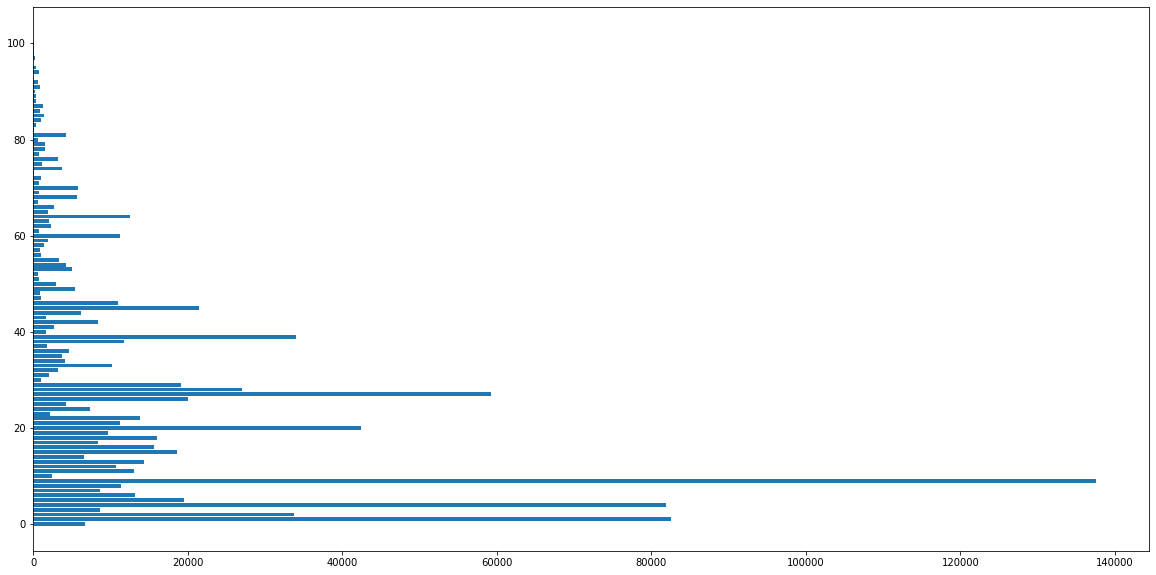

In [171]:
plt.barh(range(len(codes_amount_dict)), codes_amount_dict.values())
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

### Trying out transformer and BERT

Next I will be trying out things presented in a blog post: [Transformers for Multi-Label Classification made simple.](https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1)

I will also utilize some code from the home exercises of Deep Learning course.

#### Data splits and dataloaders

Let's split the data and make iterators for batch training.

In [6]:
# data to lists

documents = list(trunc_large_data.text.values)
labels = list(trunc_large_data.target.values)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

# encodings

encodings = tokenizer.batch_encode_plus(documents, padding='max_length', truncation=True) # tokenizer's encoding method
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [8]:
# take rows that have too rare targets

label_counts = trunc_large_data.target.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(trunc_large_data[trunc_large_data.target.astype(str).isin(one_freq)].index), reverse=True)

In [9]:
len(one_freq_idxs)

4596

In [10]:
# Gathering single instance inputs
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

In [11]:
len(input_ids)

295177

The original data is 299773 rows long, and 295177 when the unique target occurances have been separated. I will take 3 % split of these rows to mini train, and split dev and test from the remained part

In [12]:
remaining_inputs, mini_train_inputs, remaining_labels, mini_train_labels, remaining_token_types, mini_train_token_types, remaining_masks, mini_train_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=42, test_size=0.03, stratify = labels)

In [13]:
print('remaining: ', len(remaining_inputs), 'mini-train: ', len(mini_train_inputs))

remaining:  286321 mini-train:  8856


In [14]:
# splitting the dataset further, now getting the dev mini set

remaining_inputs2, mini_dev_inputs, remaining_labels2, mini_dev_labels, remaining_token_types2, mini_dev_token_types, remaining_masks2, mini_dev_masks = train_test_split(remaining_inputs, remaining_labels, remaining_token_types, remaining_masks,
                                                            random_state=42, test_size=0.03, stratify = remaining_labels)

In [15]:
print('remaining2: ', len(remaining_inputs2), 'mini-dev: ', len(mini_dev_inputs))

remaining2:  277731 mini-dev:  8590


In [16]:
# and then splitting the test set

remaining_inputs3, mini_test_inputs, remaining_labels3, mini_test_labels, remaining_token_types3, mini_test_token_types, remaining_masks3, mini_test_masks = train_test_split(remaining_inputs2, remaining_labels2, remaining_token_types2, remaining_masks2,
                                                            random_state=42, test_size=0.03, stratify = remaining_labels2)


In [17]:
print('remaining3: ', len(remaining_inputs3), 'mini-dev: ', len(mini_test_inputs))

remaining3:  269399 mini-dev:  8332


I will initially include all the 4596 one_freq rows in the mini_train_data, this can be changed later

In [18]:
mini_train_inputs.extend(one_freq_input_ids)
mini_train_labels.extend(one_freq_labels)
mini_train_masks.extend(one_freq_attention_masks)
mini_train_token_types.extend(one_freq_token_types)

In [20]:
# change mini train sets to tensors

t_mini_train_inputs = torch.tensor(mini_train_inputs)
t_mini_train_labels = torch.tensor(mini_train_labels)
t_mini_train_masks = torch.tensor(mini_train_masks)
t_mini_train_token_types = torch.tensor(mini_train_token_types)

In [19]:
# change mini dev sets to tensors

t_mini_dev_inputs = torch.tensor(mini_dev_inputs)
t_mini_dev_labels = torch.tensor(mini_dev_labels)
t_mini_dev_masks = torch.tensor(mini_dev_masks)
t_mini_dev_token_types = torch.tensor(mini_dev_token_types)

In [21]:
# change mini test sets to tensors

t_mini_test_inputs = torch.tensor(mini_test_inputs)
t_mini_test_labels = torch.tensor(mini_test_labels)
t_mini_test_masks = torch.tensor(mini_test_masks)
t_mini_test_token_types = torch.tensor(mini_test_token_types)

In [22]:
print(t_mini_train_inputs.shape)
print(t_mini_train_labels.shape)
print(t_mini_train_masks.shape)
print(t_mini_train_token_types.shape)

torch.Size([13452, 512])
torch.Size([13452, 126])
torch.Size([13452, 512])
torch.Size([13452, 512])


In [29]:
# create train iterator with torch dataloader

batch_size = 16

mini_train_data = TensorDataset(t_mini_train_inputs, t_mini_train_masks, t_mini_train_labels, t_mini_train_token_types)
mini_train_sampler = RandomSampler(mini_train_data)
mini_train_dataloader = DataLoader(mini_train_data, sampler=mini_train_sampler, batch_size=batch_size)


In [24]:
# create dev iterator with torch dataloader

mini_dev_data = TensorDataset(t_mini_dev_inputs, t_mini_dev_masks, t_mini_dev_labels, t_mini_dev_token_types)
mini_dev_sampler = SequentialSampler(mini_dev_data)
mini_dev_dataloader = DataLoader(mini_dev_data, sampler=mini_dev_sampler, batch_size=batch_size)

In [25]:
# create test iterator with torch dataloader

mini_test_data = TensorDataset(t_mini_test_inputs, t_mini_test_masks, t_mini_test_labels, t_mini_test_token_types)
mini_test_sampler = SequentialSampler(mini_test_data)
mini_test_dataloader = DataLoader(mini_test_data, sampler=mini_test_sampler, batch_size=batch_size)

In [30]:
# save (file sizes are around 95-180 MB for mini loaders, so these are gitignored)

torch.save(mini_train_dataloader,'data-loaders/mini_train_data_loader')

In [26]:

torch.save(mini_dev_dataloader,'data-loaders/mini_dev_data_loader')
torch.save(mini_test_dataloader,'data-loaders/mini_test_data_loader')

### Shortcut

If there is a saved dataloader, this can be the startpoint

In [4]:
loaded_mini_train_dataloader = torch.load('data-loaders/mini-train_data_loader')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/hdheli/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### Model loading, initial optimizer and criterion

The huggingface transformers have AdamW that has gradient bias correction and weight decay. The optimizer hyperparemeters can be [customised](https://huggingface.co/transformers/training.html), but I start simple with the default settings.

In [7]:
# Model 1

NUM_LABELS = 126 # amount of the different topics
ADAM_DEFAULT_LR = 1e-5

model_1 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS)
model_1.to(device)

optimizer_1 = AdamW(model_1.parameters(), lr=ADAM_DEFAULT_LR)
criterion_1 = BCEWithLogitsLoss() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
# Utility

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [9]:
# --- Train Loop ---

import time

def train_loop(model, model_name, optimizer, criterion, n_epochs, dataloader):
    train_losses = []
    model.train()
    steps = 0
    examples = 0
    all_batch_losses = []
    
    for epoch in range(n_epochs):
        start_time = time.time()
        epoch_loss = 0
        batch_losses = []
        for step, batch in enumerate(dataloader):
            batch_start_time = time.time()
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels, b_token_types = batch # unpack from dataloader
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]
            loss = criterion(logits.view(-1, NUM_LABELS),b_labels.type_as(logits).view(-1,NUM_LABELS)) #convert labels to float for calculation

            # Backward pass
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            examples += b_input_ids.size(0)
            steps += 1
            batch_end_time = time.time() 
            
            # Loss check
            loss_check = epoch_loss/(step+1)
            batch_losses.append(loss_check)
            batch_mins, batch_secs = epoch_time(batch_start_time, batch_end_time)
            print(f'Epoch: {epoch+1:02} | Step {step} | Batch time: {batch_mins}m {batch_secs}s')
            print(f'\tLoss check: {loss_check:.3f}')
        
        torch.save(model.state_dict(), model_name)    
        train_loss = epoch_loss / len(dataloader)
        train_losses.append(train_loss)
        all_batch_losses.append(batch_losses)
            
        end_time = time.time()
            
        epoch_mins, epoch_secs = epoch_time(batch_start_time, batch_end_time)
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        
            
    return model, train_losses, all_batch_losses

In [10]:
# train model 1, just one epoch to test

n_epochs_1 = 1

trained_model_1, train_losses, batch_losses = train_loop(model_1, OUTPUT_FOLDER+'/model_1_270321', optimizer_1, criterion_1, n_epochs_1, loaded_mini_train_dataloader)


unloaded dim torch.Size([48, 256]) torch.Size([48, 256]) torch.Size([48, 126]) torch.Size([48, 256])
logits tensor([[-0.3708,  0.3800, -0.3711,  ..., -0.2434,  0.3016,  0.4135],
        [-0.1564,  0.4655, -0.4990,  ..., -0.2637, -0.2344,  0.2109],
        [-0.3535,  0.5852, -0.7945,  ...,  0.1883, -0.0653,  0.4057],
        ...,
        [-0.0694,  0.0340, -0.3414,  ..., -0.1565,  0.2508,  0.0862],
        [-0.2443,  0.3665, -0.6011,  ..., -0.0867, -0.0059,  0.3010],
        [-0.2932,  0.5382, -0.7429,  ...,  0.0548,  0.1851,  0.1194]],
       grad_fn=<AddmmBackward>)


KeyboardInterrupt: 